# Egg detection via bounding box regression

A notebook outlining the training procedure using a variety of best performing image classification models as the model 'backbone' for this problem. Because this is an object detection problem involving only single instances of embryos in a given image, there is no need for a region proposal head that generates multiple regions of interest for a given image. Because of this, we can greatly simply the model structure, namely by using bounding box regression at the output of a model to generate the bounding box coordinates for where an egg is located in a given image.


### Dependencies

The following are required dependencies for this script. We also set up mixed precision training for the speedup it provides in training time. 

In [1]:
import glob
import vuba
import random
import numpy as np
import cv2
import vuba
from tensorflow import keras
import re
from tensorflow.keras import layers
from tqdm import tqdm
import pandas as pd
import ast
import tensorflow as tf
import time
import datetime

from keras.applications import *

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6


## Script-wide parameters and Model backbones

The following are the model parameters I used to train these models, as well as the specific image classification models used for this problem. Some of these models from ```keras``` have in-built pre-processing methods hence the addition of different parameters for each model. These models are on the smaller end of the scale when it comes to model size and this was done specifically from a training time standpoint, as well as the possibility for these models to be used in embedded applications within the research group. 

In [2]:
# Parameters ----------------------------------------------------------
batch_size = 16
input_shape = (512, 512, 1)
epochs = 10 # First train with 10 epochs to identify best performing model, then repeat training with 25-50 epochs with only best performing model
model_save_dir = './trained_models'
# ---------------------------------------------------------------------

models = [
    (Xception, 'Xception', dict(include_preprocessing=True, method=xception.preprocess_input)),
    (ResNet50, 'ResNet50', dict(include_preprocessing=False, method=None)),
    (ResNet101, 'ResNet101', dict(include_preprocessing=False, method=None)),
    (InceptionV3, 'InceptionV3', dict(include_preprocessing=True, method=inception_v3.preprocess_input)),
    (InceptionResNetV2, 'InceptionResNetV2', dict(include_preprocessing=True, method=inception_resnet_v2.preprocess_input)),
    (MobileNet, 'MobileNet', dict(include_preprocessing=True, method=mobilenet.preprocess_input)),
    (DenseNet121, 'DenseNet121', dict(include_preprocessing=False, method=None)),
    (NASNetMobile, 'NASNetMobile', dict(include_preprocessing=False, method=None)),
    (EfficientNetB0, 'EfficientNetB0', dict(include_preprocessing=True, method=efficientnet.preprocess_input)),
    (EfficientNetV2B0, 'EfficientNetV2B0', dict(include_preprocessing=False, flag=False, method=None)),
    (EfficientNetV2S, 'EfficientNetV2S', dict(include_preprocessing=False, flag=False, method=None)),
    (EfficientNetV2M, 'EfficientNetV2M', dict(include_preprocessing=False, flag=False, method=None))
]

## Model creation

The function below is a convenience method for building a model that performs single instance object detection, given a specified model backbone. Note the bounding box regression head, this is a very simple method for providing an output of 4 values corresponding to the bounding box coordinates, however it serves as a good enough test for the different backbones before proceeding onto optimisation.

In [3]:
def model_build(backbone, preprocessing_kwargs, input_shape):
    inputs = keras.Input(shape=input_shape)

    if preprocessing_kwargs['include_preprocessing']:
        if preprocessing_kwargs['method'] is not None:
            input_tensor = preprocessing_kwargs['method'](inputs)
        else:
            print('No rescaling.')
            input_tensor = inputs
    else:
        input_tensor = layers.Rescaling(1.0 / 255)(inputs)

    kwargs = dict(
        weights=None, 
        input_tensor=input_tensor, 
        include_top=False
    ) 

    if 'flag' in preprocessing_kwargs.keys():
        kwargs['include_preprocessing'] = False

    classifier_backbone = backbone(**kwargs)
    x = classifier_backbone.output
    
    # Bounding box regression head
    if 'avg_pool' not in preprocessing_kwargs.keys():
        x = layers.GlobalAveragePooling2D()(x)
        
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
        
    outputs = layers.Dense(4, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)

    return model


## Dataset pipeline

The following dataset pipeline is using an augmented dataset generated from a pre-trained semantic segmentation model (HRNet V2). Here, I have simply used tensorflow's dataset pipeline to batch process this dataset out-of-core to overcome memory limitations on my system.

In [4]:
def read_data(fn, box):
    img = tf.io.read_file(fn)
    img = tf.image.decode_png(img, channels=1)
    img.set_shape([None, None, 1])
    img = tf.image.resize(images=img, size=[512, 512])

    return img, box

# tf.data.dataset pipeline ----------------
def get_data(dataset):
    image_fn = list(dataset['filename'])

    boxes = []
    for x1,y1,x2,y2 in zip(dataset['x1'], dataset['y1'], dataset['x2'], dataset['y2']):
        boxes.append((x1 / 512, y1 / 512, x2 / 512, y2 / 512))

    return image_fn, boxes

def dataset(df, batch_size):
    images, boxes = get_data(df)
    
    data = tf.data.Dataset.from_tensor_slices((images, boxes))
    data = data.map(read_data, num_parallel_calls=tf.data.AUTOTUNE)
    data = data.batch(batch_size, drop_remainder=True)
        
    return data

# Training data...
train_df = pd.read_csv('./train_annotations.csv').sample(frac=1).reset_index(drop=True)
val_df = pd.read_csv('./val_annotations.csv').sample(frac=1).reset_index(drop=True)
test_df = pd.read_csv('./test_annotations.csv').sample(frac=1).reset_index(drop=True)

train_data = dataset(train_df, batch_size)
val_data = dataset(val_df, batch_size)
test_data = dataset(test_df, batch_size)

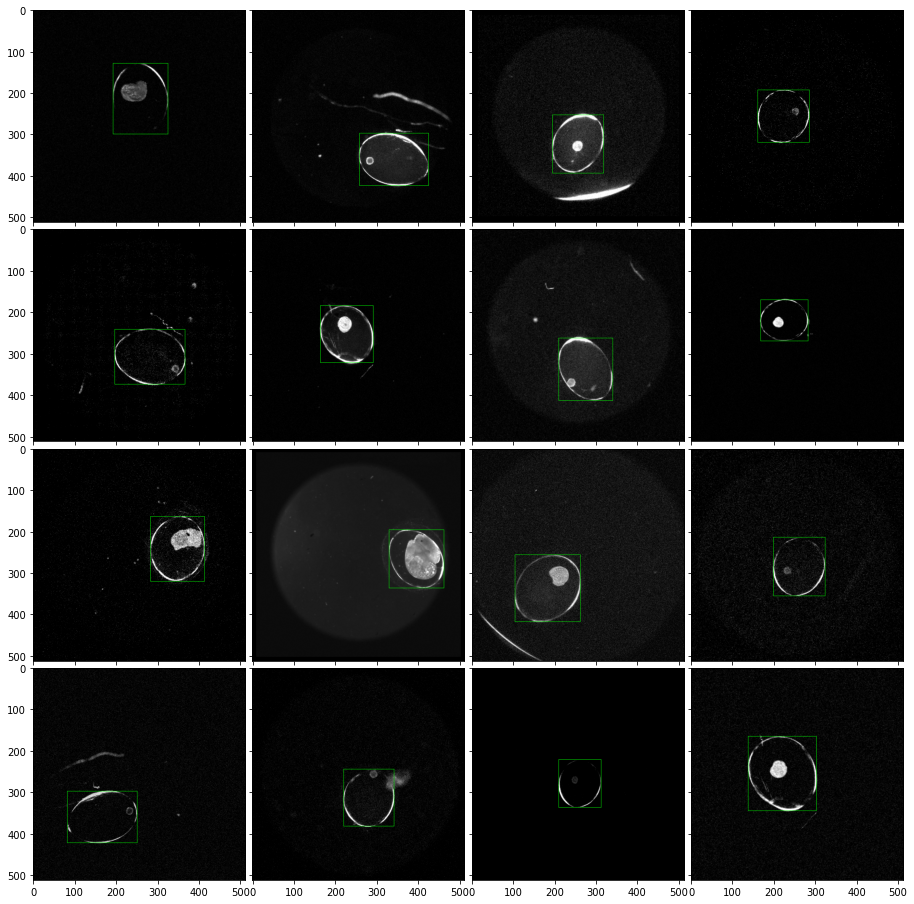

In [5]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import ImageGrid

# Test data
for batch in train_data:
    first_batch = batch
    break

images, boxes = first_batch

# 4x4 grid for batch size of 16
fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,
             nrows_ncols=(4, 4),
             axes_pad=0.1,
)

for i, (im, truth, ax) in enumerate(zip(images, boxes, grid)):
    
    # Ground truths
    truth = tuple(np.asarray(truth*512))
    truth = tuple(map(int, truth)) 
    
    im = np.asarray(im[:,:,0]).astype(np.uint8)
    im = vuba.bgr(im)
    
    x1,y1,x2,y2 = truth
    cv2.rectangle(im, (x1,y1), (x2,y2), (0,255,0), 1) # Ground truth in green
        
    ax.imshow(im)

plt.show()
    

## Model training and logging

This is the main training loop for constructing, training and computing summary metrics for each model. For each model I used the Adam optimizer as well as MSE for loss. MSE was required given that this is a regression problem. 

In [6]:
# Model training -------------------------------------------------
model_stats = dict(
    name=[],
    loss=[],
    val_loss=[],
    test_loss=[],
    accuracy=[],
    val_accuracy=[],
    test_accuracy=[],
    params=[],
    total_train_time=[],
    per_epoch_time=[]
)

# Training models...
for params in models:
    backbone, name, preprocessing_kwargs = params

    print('---------------------------------')
    print(f'Training: {name}')
    print('---------------------------------')        
    
    model = model_build(backbone, preprocessing_kwargs, input_shape)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss=keras.losses.MeanSquaredError(),
        metrics=['accuracy']
    )

    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=f'{model_save_dir}/{name}_egg_bbox_512_{epochs}_epochs.h5',
            save_best_only=True,
            monitor='val_accuracy'
        )
    ]

    start = time.time()
    history = model.fit(
        train_data,
        epochs=epochs, 
        callbacks=callbacks,
        validation_data=val_data)        
    end = time.time()
    
    test_loss, test_accuracy = model.evaluate(test_data)
    
    model_stats['name'].append(name)
    model_stats['loss'].append(max(history.history['loss']))
    model_stats['val_loss'].append(max(history.history['val_loss']))
    model_stats['test_loss'].append(test_loss)
    model_stats['accuracy'].append(max(history.history['accuracy']))
    model_stats['val_accuracy'].append(max(history.history['val_accuracy']))
    model_stats['test_accuracy'].append(test_accuracy)
    model_stats['params'].append(model.count_params())
    model_stats['total_train_time'].append(end - start)
    model_stats['per_epoch_time'].append((end - start) / epochs)

    del model
    keras.backend.clear_session()

# Summary statistics
df = pd.DataFrame(data=model_stats)
df.to_csv('./egg_bbox_512_model_stats_convnext.csv')

---------------------------------
Training: Xception
---------------------------------
Epoch 1/25
4326/4326 [==============================] - 767s 175ms/step - loss: 6.5931e-04 - accuracy: 0.9475 - val_loss: 4.8786e-04 - val_accuracy: 0.9768
Epoch 2/25
4326/4326 [==============================] - 753s 174ms/step - loss: 9.1970e-05 - accuracy: 0.9821 - val_loss: 4.0423e-04 - val_accuracy: 0.9802
Epoch 3/25
4326/4326 [==============================] - 753s 174ms/step - loss: 4.4983e-05 - accuracy: 0.9877 - val_loss: 3.9653e-04 - val_accuracy: 0.9831
Epoch 4/25
4326/4326 [==============================] - 752s 174ms/step - loss: 3.2779e-05 - accuracy: 0.9910 - val_loss: 5.0490e-04 - val_accuracy: 0.9828
Epoch 5/25
4326/4326 [==============================] - 752s 174ms/step - loss: 2.4080e-05 - accuracy: 0.9918 - val_loss: 3.7130e-04 - val_accuracy: 0.9839
Epoch 6/25
4326/4326 [==============================] - 752s 174ms/step - loss: 1.5797e-05 - accuracy: 0.9933 - val_loss: 3.9438e-04 

## Final visual validation

Xception
1/1 [==============================] - 1s 786ms/step


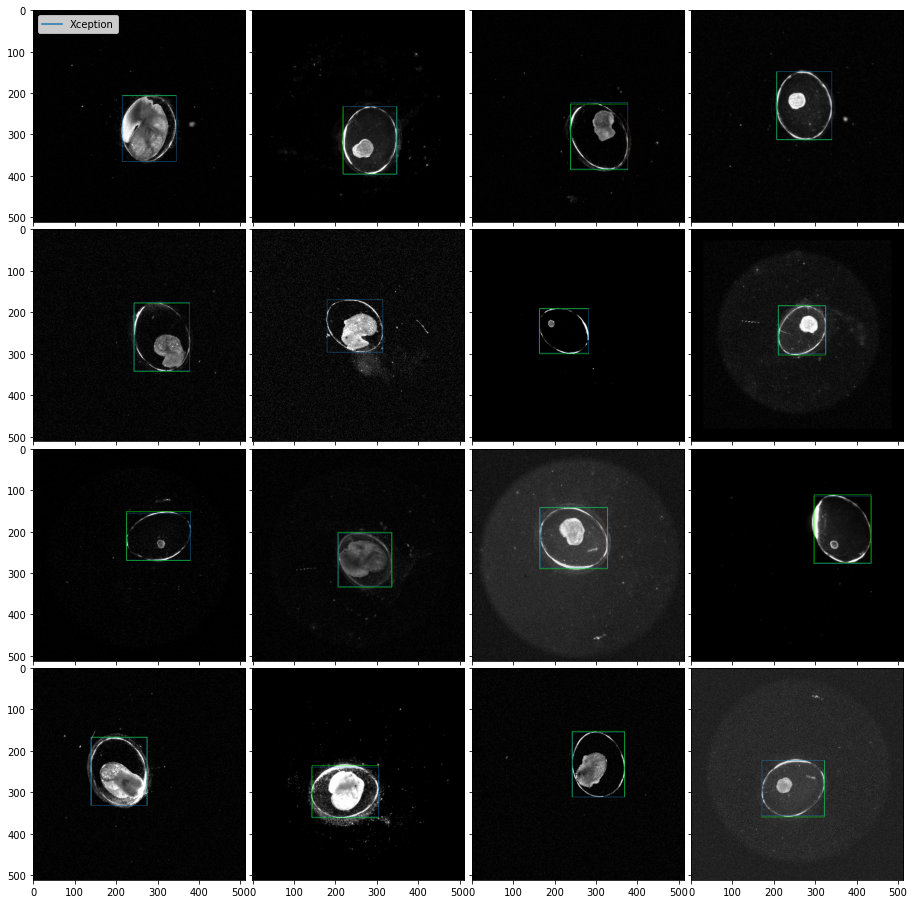

In [7]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import ImageGrid

test_df = pd.read_csv('./test_annotations.csv').sample(frac=1).reset_index(drop=True)
test_data = dataset(test_df, batch_size)

for batch in test_data:
    images, boxes = batch
    break

# Test models
# 4x4 grid for batch size of 16
fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,
             nrows_ncols=(4, 4),
             axes_pad=0.1,
)

results = []
for params in models:
    backbone, name, preprocessing_kwargs = params
    print(name)
    model = model_build(backbone, preprocessing_kwargs, input_shape)
    model.load_weights(f'{model_save_dir}/{name}_egg_bbox_512_{epochs}_epochs.h5')
    
    test_out = model.predict(images)
    results.append(np.asarray(test_out))
    
    del model
    keras.backend.clear_session()
    
for i, (im, truth, ax) in enumerate(zip(images, boxes, grid)):
    
    # Ground truths
    truth = tuple(np.asarray(truth*512))
    truth = tuple(map(int, truth)) 
    
    im = np.asarray(im[:,:,0]).astype(np.uint8)
    im = vuba.bgr(im)
    
    x1,y1,x2,y2 = truth
    cv2.rectangle(im, (x1,y1), (x2,y2), (0,255,0), 1) # Ground truth in green
        
    # Model results
    for j,r in enumerate(results):
        r = r[i]
        r = tuple(np.asarray(r*512))
        r = tuple(map(int, r)) 
        
        rgb = matplotlib.colors.to_rgb(f'C{j}')
        rgb = np.asarray(rgb) * 255
        rgb = tuple(map(round, rgb))
        
        x1,y1,x2,y2 = r
        cv2.rectangle(im, (x1,y1), (x2,y2), rgb, 1)

        if i == 0:
            ax.plot(r[0], r[1], color=f'C{j}', label=models[j][1])

    ax.imshow(im)
    
    if i == 0:
        ax.legend(loc='upper left')

plt.show()